# Computer Vision Coursework: Face Covering Detection

- **Name:** Sajeel Nadeem Alam
- **ID:** 240045404



# Google Colab Setup

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_function.ipynb', 'Code', 'Models', 'Personal_Video', 'CW_Dataset']


Getting data from drive - Lab06

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

replace __MACOSX/._CV2024_CW_Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/test/._images? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/test/._labels? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/train/._images? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/train/._labels? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2024_CW_Dataset/test/images/image_2711.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/test/images/._image_2711.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV2024_CW_Dataset/test/images/image_2654.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CV2024_CW_Dataset/test/images/._image_2654.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CV202

# Importing Essential Libraries

In [ ]:
import os
from skimage import io
import matplotlib.pyplot as plt

import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score
from collections import Counter

In [ ]:
randomState = 42

# Reading Data (Lab 4)

In [ ]:
dataset_path = "./CV2024_CW_Dataset"

for root, dirs, files in os.walk(dataset_path):
    print(root, "contains", len(files), "files")

./CV2024_CW_Dataset contains 0 files
./CV2024_CW_Dataset/test contains 0 files
./CV2024_CW_Dataset/test/labels contains 458 files
./CV2024_CW_Dataset/test/images contains 458 files
./CV2024_CW_Dataset/train contains 0 files
./CV2024_CW_Dataset/train/labels contains 2394 files
./CV2024_CW_Dataset/train/images contains 2394 files


In [ ]:
def import_selected_data(images_path, labels_path):  # Lab06
    images = []
    labels = []

    filenames = [file for file in sorted(os.listdir(images_path)) if file.endswith('.jpeg')]

    for file in filenames:
        img_path = os.path.join(images_path, file)
        img = io.imread(img_path)
        images.append(img)

        label_filename = os.path.splitext(file)[0] + ".txt"
        label_path = os.path.join(labels_path, label_filename)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = f.read().strip()
        else:
            label = None

        labels.append(label)

    return images, labels

In [ ]:
trainImagesPath = "CV2024_CW_Dataset/train/images"
trainLabelsPath = "CV2024_CW_Dataset/train/labels"
testImagesPath = "CV2024_CW_Dataset/test/images"
testLabelsPath = "CV2024_CW_Dataset/test/labels"

xTrain, yTrain = import_selected_data(trainImagesPath, trainLabelsPath)
xTest, yTest = import_selected_data(testImagesPath, testLabelsPath)

print(f"Loaded {len(xTrain)} training images and {len(yTrain)} labels")
print(f"Loaded {len(xTest)} testing images and {len(yTest)} labels")

print("Training Images classes", Counter(yTrain))
print("Testing Images classes", Counter(yTest))

Loaded 2394 training images and 2394 labels
Loaded 458 testing images and 458 labels
Training Images classes Counter({'1': 1940, '0': 376, '2': 78})
Testing Images classes Counter({'1': 388, '0': 51, '2': 19})


Displaying Sample Image

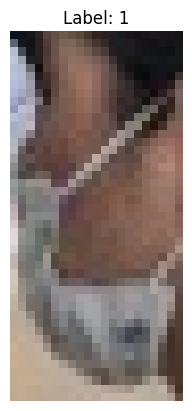

In [ ]:
sample_image = xTrain[-1]
sample_label = yTrain[-1]

plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

# Interest point detection and feature descriptor extraction using SIFT (Lab 6)

In [ ]:
sift = cv2.SIFT_create()

def getFeatureDescriptors(images, labels):
  descriptorsList = []
  labelsList = []

  for i in range(len(images)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(images[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Append list of descriptors and label to respective lists
    if des is not None:
        descriptorsList.append(des)
        labelsList.append(labels[i])

  return descriptorsList, labelsList

descriptorsList, yTrainLabels = getFeatureDescriptors(xTrain, yTrain)
descriptorsTrainArray = np.vstack(descriptorsList)

# Hyperparameter fine-tuning (SVM)

Setting up hyperparameter space

In [ ]:
kValues = [15, 30, 45, 60]
svmCValues = [0.1, 1, 10]
svmGammaValues = [0.01, 0.1, 1]

Grid Search

In [ ]:
bestScore = float('inf')
bestParams = None
bestClassifier = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for k in kValues:
    print(f"Training KMeans with k = {k} ...")

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

    # Convert descriptors into histograms of codewords for each image
    histogramList = []
    for des in descriptorsList:
        hist = np.zeros(k)
        idx = kmeans.predict(des)  # tells us which codeword (index) each descriptor in the image belongs to in a list
        for j in idx:              # creates normalised histogram of codewords for each image
            hist[j] = hist[j] + (1 / len(des))
        histogramList.append(hist)

    histogramArrayTrain = np.vstack(histogramList)

    svmModel = svm.SVC(kernel='rbf', probability=True, random_state=randomState)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

    paramGrid = {
        'C': svmCValues,
        'gamma': svmGammaValues
    }

    gridSearch = GridSearchCV(
        svmModel,
        paramGrid,
        cv=cv,
        scoring=scoring,
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=3
    )

    gridSearch.fit(histogramArrayTrain, yTrainLabels)

    if -(gridSearch.best_score_) < bestScore:
        bestScore = -(gridSearch.best_score_)
        bestParams = {'k': k}
        bestParams.update(gridSearch.best_params_)
        bestClassifier = gridSearch.best_estimator_

print(f"Best Parameters: {bestParams}")
print(f"Best Negative Log Loss: {bestScore:.4f}")

Training KMeans with k = 15 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 30 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 45 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 60 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'k': 60, 'C': 10, 'gamma': 1}
Best Negative Log Loss: 0.4847


# Evaluating best model on test set (SVM)

In [ ]:
bestK = bestParams['k']
kmeansBest = KMeans(n_clusters=bestK, n_init='auto', random_state=42).fit(descriptorsTrainArray)

Creating normalised histogram of codewords for testing set

In [ ]:
histogramTestList = []

for i in range(len(xTest)):
    img = img_as_ubyte(color.rgb2gray(xTest[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)
        idx = kmeansBest.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        # hist = scale.transform(hist.reshape(1, -1))
        histogramTestList.append(hist)
    else:
        histogramTestList.append(None)

# Remove potential cases of images with no descriptors
idxNotEmpty = [i for i, x in enumerate(histogramTestList) if x is not None]
histogramTestList = [histogramTestList[i] for i in idxNotEmpty]
yTest = [yTest[i] for i in idxNotEmpty]
histogramTestArray = np.vstack(histogramTestList)

In [ ]:
yPred = bestClassifier.predict(histogramTestArray).tolist()

In [ ]:
print(f"""Classification report for classifier {bestClassifier}:
      {classification_report(yTest, yPred, zero_division=0)}\n""")

precision, recall, f1, _ = precision_recall_fscore_support(yTest, yPred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification report for classifier SVC(C=10, gamma=1, probability=True, random_state=42):
                    precision    recall  f1-score   support

           0       0.43      0.18      0.25        50
           1       0.87      0.97      0.92       384
           2       0.00      0.00      0.00        19

    accuracy                           0.85       453
   macro avg       0.43      0.38      0.39       453
weighted avg       0.78      0.85      0.81       453


Precision: 0.7811766354812713
Recall: 0.8454746136865342
F1 Score: 0.8050244069272144


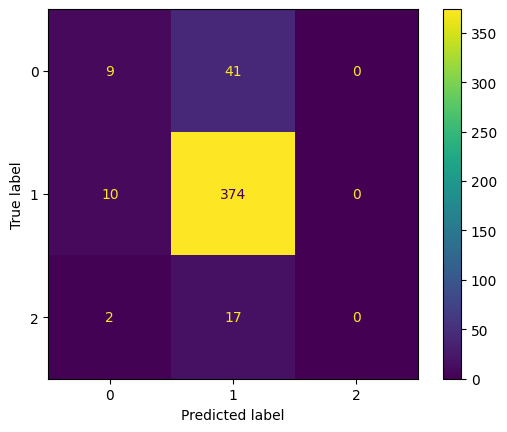

In [ ]:
class_labels = ['0', '1', '2']
cm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()